# GAN (context encoder)

## 0. import libraries


In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.python.keras.models import load_model    
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, UpSampling1D, Conv2DTranspose
from keras.models import Sequential, Model
from keras import losses
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from __future__ import print_function, division

## 1. context encoder (25% missing window)
####      the code of deep generative model is based on https://github.com/eriklindernoren/Keras-GAN/tree/master/context_encoder.

In [219]:
img_rows, img_cols = 128, 1
mask_height, mask_width = 32, 1
channels = 3
img_shape = (img_rows, img_cols, channels)
missing_shape = (mask_height, mask_width, channels)
optimizer = Adam(0.0002, 0.5)

In [220]:
def build_generator():
        model = Sequential()
        # Encoder
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))    
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(512, kernel_size=1, strides=2, padding="same"))     
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        # Decoder
        model.add(Conv2DTranspose(128, kernel_size=3, strides = (2,1), padding="same"))    
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(64, kernel_size=3, strides = (2,1), padding="same"))    
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(64, kernel_size=3, strides = (2,1), padding="same"))    
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(channels, kernel_size=3, strides = (1,1), padding="same"))    
        model.add(Activation('tanh'))

        model.summary()

        masked_img = Input(shape=img_shape)
        gen_missing = model(masked_img)

        return Model(masked_img, gen_missing)

In [221]:
generator = build_generator()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_170 (Conv2D)         (None, 64, 1, 32)         896       
                                                                 
 leaky_re_lu_170 (LeakyReLU)  (None, 64, 1, 32)        0         
                                                                 
 batch_normalization_204 (Ba  (None, 64, 1, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_171 (Conv2D)         (None, 32, 1, 64)         18496     
                                                                 
 leaky_re_lu_171 (LeakyReLU)  (None, 32, 1, 64)        0         
                                                                 
 batch_normalization_205 (Ba  (None, 32, 1, 64)        256       
 tchNormalization)                                   

In [222]:
def build_discriminator():
        model = Sequential()
        model.add(Conv2D(32, kernel_size=3, strides=(2,1), input_shape=missing_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=(2,1), input_shape=missing_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=(2,1), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=(2,1), padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=missing_shape)
        validity = model(img)

        return Model(img, validity)

In [223]:
discriminator = build_discriminator()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_175 (Conv2D)         (None, 16, 1, 32)         896       
                                                                 
 leaky_re_lu_175 (LeakyReLU)  (None, 16, 1, 32)        0         
                                                                 
 batch_normalization_211 (Ba  (None, 16, 1, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_176 (Conv2D)         (None, 8, 1, 64)          18496     
                                                                 
 leaky_re_lu_176 (LeakyReLU)  (None, 8, 1, 64)         0         
                                                                 
 batch_normalization_212 (Ba  (None, 8, 1, 64)         256       
 tchNormalization)                                   

In [224]:
# for testing
pos_l = [i * 5 for i in range(5,6)] #(0,20)] 
def mask_position(imgs, pos):
    y1 = np.random.randint(pos, pos+1, imgs.shape[0])    # initial prototype -> origin pos = 50
    y2 = y1 + mask_height

    masked_imgs = np.empty_like(imgs)
    missing_parts = np.empty((imgs.shape[0], mask_height, mask_width, channels))
    for i, img in enumerate(imgs):
        masked_img = img.copy()
        y1p, y2p= y1[i], y2[i]
        missing_parts[i] = masked_img[y1p:y2p, 0:1, :].copy()
        masked_img[y1p:y2p,0:1, :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs, missing_parts, (y1, y2)


# for training
def mask_randomly( imgs):
    y1 = np.random.randint(0, img_rows-mask_height, imgs.shape[0])
    y2 = y1 + mask_height

    masked_imgs = np.empty_like(imgs)
    missing_parts = np.empty((imgs.shape[0], mask_height, mask_width, channels))
    for i, img in enumerate(imgs):
        masked_img = img.copy()
        y1p, y2p= y1[i], y2[i]
        missing_parts[i] = masked_img[y1p:y2p, 0:1, :].copy()
        masked_img[y1p:y2p,0:1, :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs, missing_parts, (y1, y2)

In [225]:
def train(X_train, y_train, X_test, y_test, epochs, batch_size=128, sample_interval=50):
        d_loss_list = []
        g_loss_list = []

        X_train = X_train / 127.5 - 1.
        y_train = y_train.reshape(-1, 1)
        X_test = X_test / 127.5 - 1.
        y_test = y_test.reshape(-1, 1)        

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            masked_imgs, missing_parts, _ = mask_randomly(imgs)
            gen_missing = generator.predict(masked_imgs)

            d_loss_real = discriminator.train_on_batch(missing_parts, valid)
            d_loss_fake = discriminator.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            g_loss = combined.train_on_batch(masked_imgs, [missing_parts, valid])
            d_loss_list.append(d_loss)
            g_loss_list.append(g_loss)


            if epoch % sample_interval == 0:               
                idx = np.random.randint(0, X_train.shape[0], 5)
                imgs = X_train[idx]
                sample_images(epoch, imgs)
                
            if epoch == epochs-1 : 
                tot_result = []
                tot_imgs = []
                tot_index = []
                for p in pos_l : 
                    index_list = []
                    gan_16_results_to_cnn = []
                    gan_16_imgs_to_cnn = []
                    for i in range(20): 
                        idx = np.random.randint(0, X_test.shape[0], 5)
                        index_list = index_list+idx.tolist()
                        imgs = X_test[idx]
                        gan_16_results, gan_16_imgs = result_images(imgs, i, p)    
                        gan_16_results_to_cnn.append(gan_16_results)
                        gan_16_imgs_to_cnn.append(gan_16_imgs)
                        
                    tot_result.append(gan_16_results_to_cnn)
                    tot_imgs.append(gan_16_imgs_to_cnn)
                    tot_index.append(index_list)

        return d_loss_list, g_loss_list, tot_result, tot_imgs, tot_index


In [226]:
def result_images(imgs, cnt_imgs, pos):
        gan_16_results = []
        gan_16_imgs = []
        
        r , c = 3, 5
        #masked_imgs, missing_parts, (y1, y2) = mask_position(imgs, pos)
        masked_imgs, missing_parts, (y1, y2) = mask_randomly(imgs)
        gen_missing = generator.predict(masked_imgs)

        imgs = 0.5 * imgs + 0.5    
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5
        fig, axs = plt.subplots(r, c, figsize = (15,10))

        for i in range(c):
            a = imgs[i, :,:]
            a = np.resize(a, (128,128,3))
            axs[0,i].imshow(a)
            axs[0,i].axis('off')
            axs[0,i].set_title('ori_'+str(i))
            
            gan_16_imgs.append(a[0])
                          
            b = masked_imgs[i, :,:]
            b = np.resize(b, (128,128,3) )                        
            axs[1,i].imshow(b)
            axs[1,i].axis('off')
            axs[1,i].set_title('masked_'+str(i))                         
                          
            filled_in = imgs[i].copy()
            filled_in[y1[i]:y2[i], 0:1, :] = gen_missing[i]
            c = np.resize(filled_in, (128,128,3))
            
            gan_16_results.append(c[0])
                          
            axs[2,i].imshow(c)
            axs[2,i].axis('off')
            axs[2,i].set_title('restored_'+str(i)) 
        
       # plt.savefig('/home/sbml/battery_rgb/paper_data/gan/gan_randompos/results_3000/'+str(cnt_imgs)+'.png')    
       # plt.savefig('/home/sbml/battery_rgb/220610/resize_not_intepolate/GAN/results_16/'+str(cnt_imgs)+'.svg')

        plt.show()        
        plt.close()
        
        return gan_16_results, gan_16_imgs

In [227]:
def sample_images( epoch, imgs):
        r, c = 3, 5
        masked_imgs, missing_parts, (y1, y2) = mask_randomly(imgs)
        gen_missing = generator.predict(masked_imgs)
        imgs = 0.5 * imgs + 0.5      
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5

        fig, axs = plt.subplots(r, c, figsize = (15,10))
        print(epoch)
        for i in range(c):
            a = imgs[i, :,:]
            a = np.resize(a, (128,128,3))
            axs[0,i].imshow(a)
            axs[0,i].axis('off')
            axs[0,i].set_title('ori_'+str(i))

                          
            b = masked_imgs[i, :,:]
            b = np.resize(b, (128,128,3) )                        
            axs[1,i].imshow(b)
            axs[1,i].axis('off')
            axs[1,i].set_title('masked_'+str(i))                         
                          
            filled_in = imgs[i].copy()
            filled_in[y1[i]:y2[i], 0:1, :] = gen_missing[i]
            c = np.resize(filled_in, (128,128,3))
                          
            axs[2,i].imshow(c)
            axs[2,i].axis('off')
            axs[2,i].set_title('restored_'+str(i)) 
        plt.show()       
        plt.close()        

## 2. training 

In [243]:
df = pd.read_csv('/home/sbml/battery_rgb/220503/resize_not_intepolate/data_T25.csv')
d = []
scaled_RGB = df['scaled_RGB'].tolist()
for i in scaled_RGB :
    i = eval(i)
    Extension = [i]*len(i)
    img_big = np.array(Extension, dtype = np.uint8)
    img_small = cv.resize(img_big, dsize = (128,128), interpolation  = cv.INTER_AREA)
    rgb = img_small[0]
    rgb = np.array(rgb)
    d.append(rgb)
df['scaled_rgb_resize'] = d

In [244]:
rgbList = df['scaled_rgb_resize'].tolist()
rgbList = np.array(rgbList)
label = np.array([[i] for i in df['SOH'].tolist()])
X = rgbList
y = np.array(label)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [245]:
X_train = X_train.reshape(X_train.shape[0], 128,1, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 128,1, 3).astype('float32')

In [246]:
X_test.shape

(5127, 128, 1, 3)

In [259]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

generator = build_generator()
masked_img = Input(shape=img_shape)
gen_missing = generator(masked_img)

discriminator.trainable = False
valid = discriminator(gen_missing)

combined = Model(masked_img , [gen_missing, valid])
combined.compile(loss=['mse', 'binary_crossentropy'],
    loss_weights=[0.999, 0.001],
    optimizer=optimizer)

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_210 (Conv2D)         (None, 16, 1, 32)         896       
                                                                 
 leaky_re_lu_210 (LeakyReLU)  (None, 16, 1, 32)        0         
                                                                 
 batch_normalization_252 (Ba  (None, 16, 1, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_211 (Conv2D)         (None, 8, 1, 64)          18496     
                                                                 
 leaky_re_lu_211 (LeakyReLU)  (None, 8, 1, 64)         0         
                                                                 
 batch_normalization_253 (Ba  (None, 8, 1, 64)         256       
 tchNormalization)                                   

0


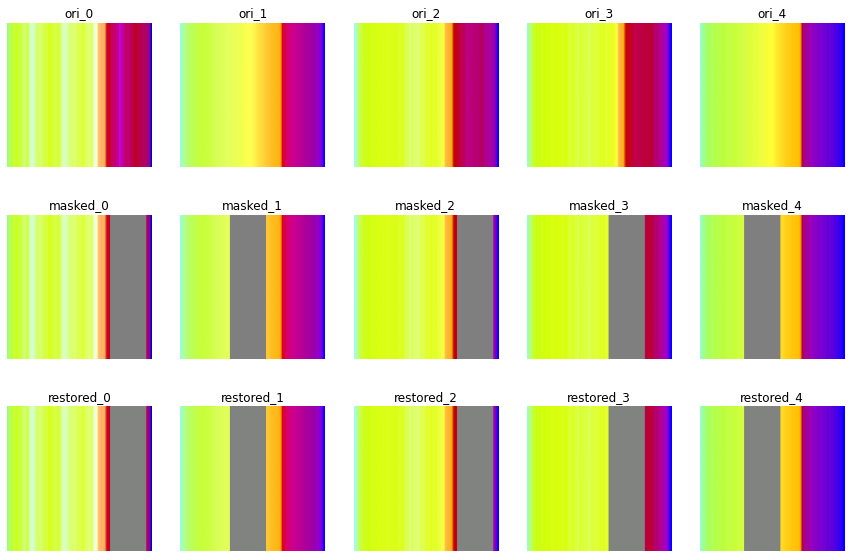

100


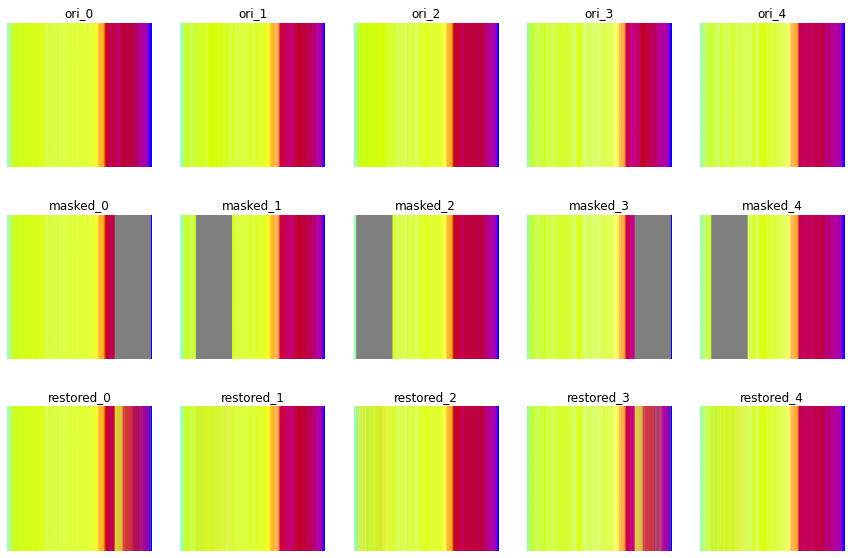

200


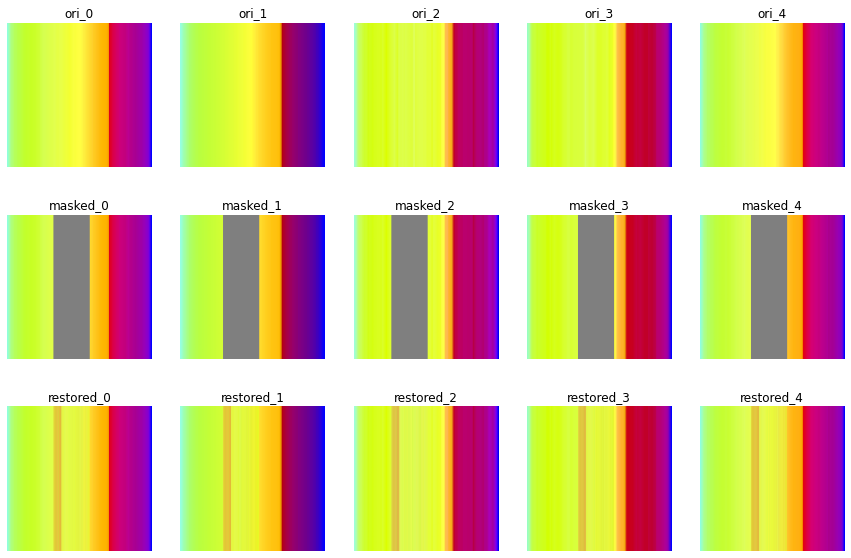

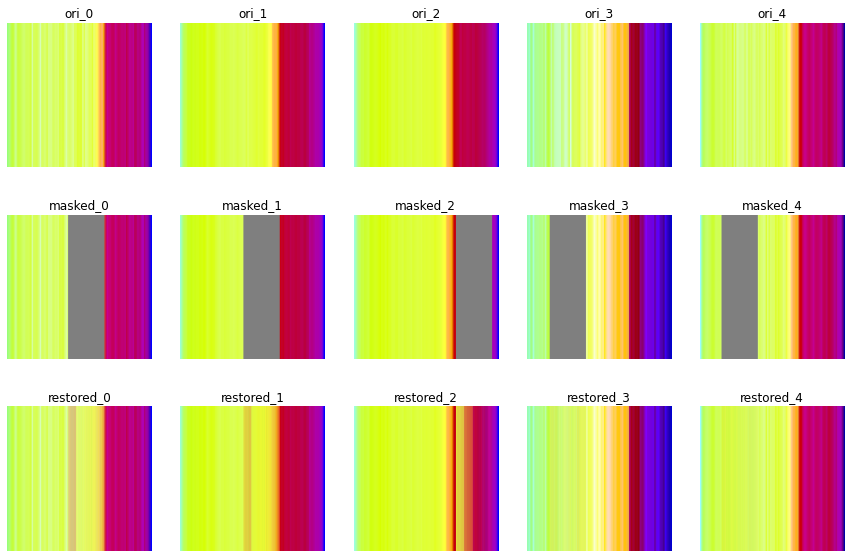

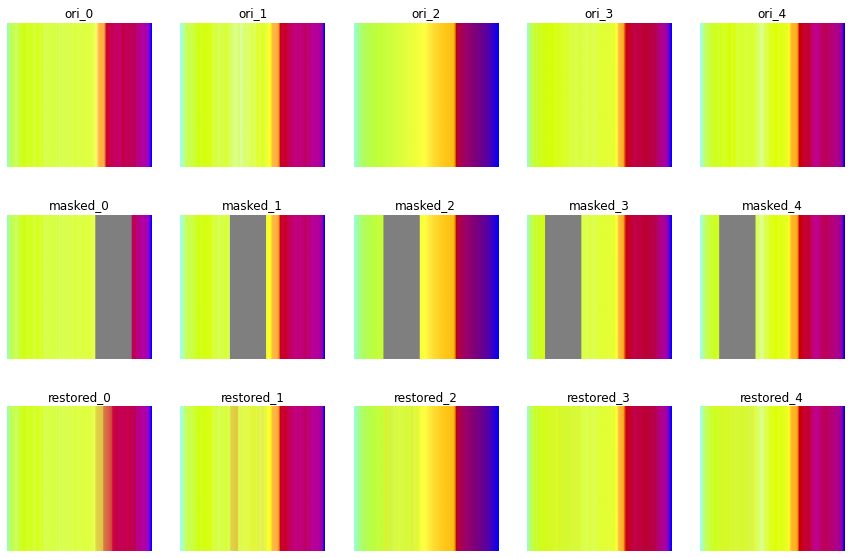

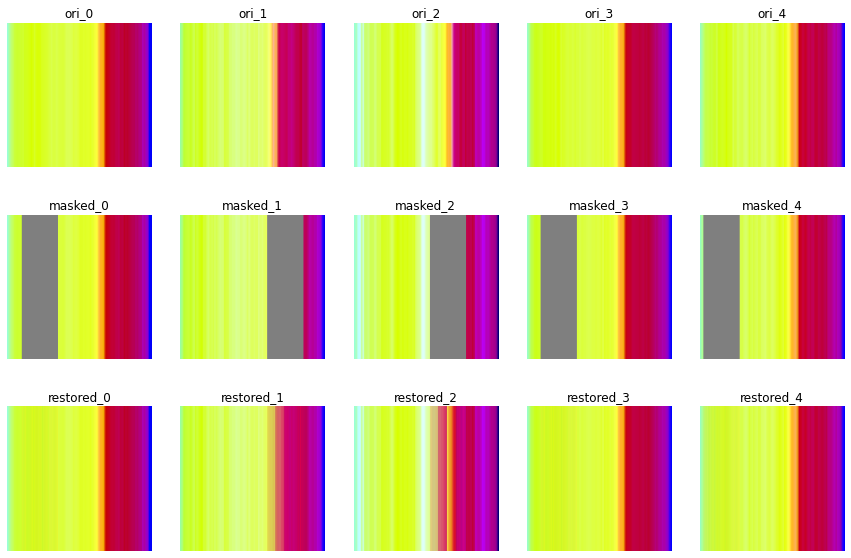

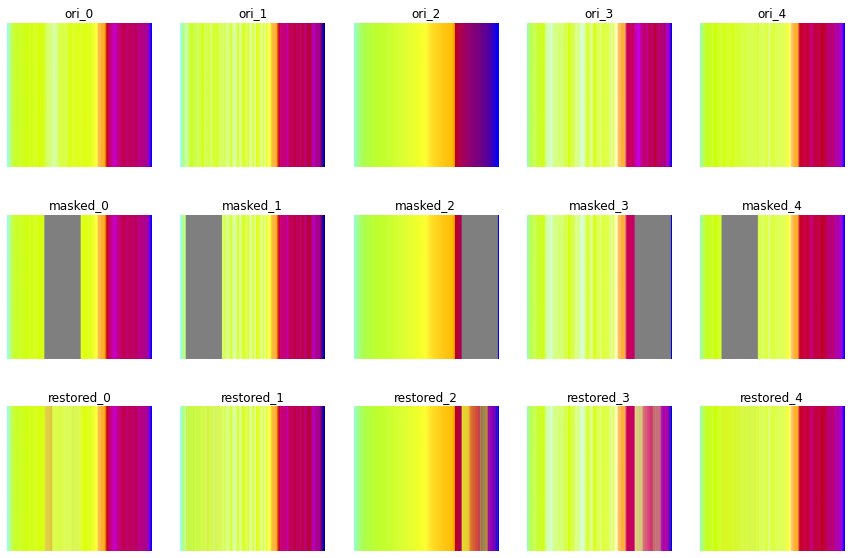

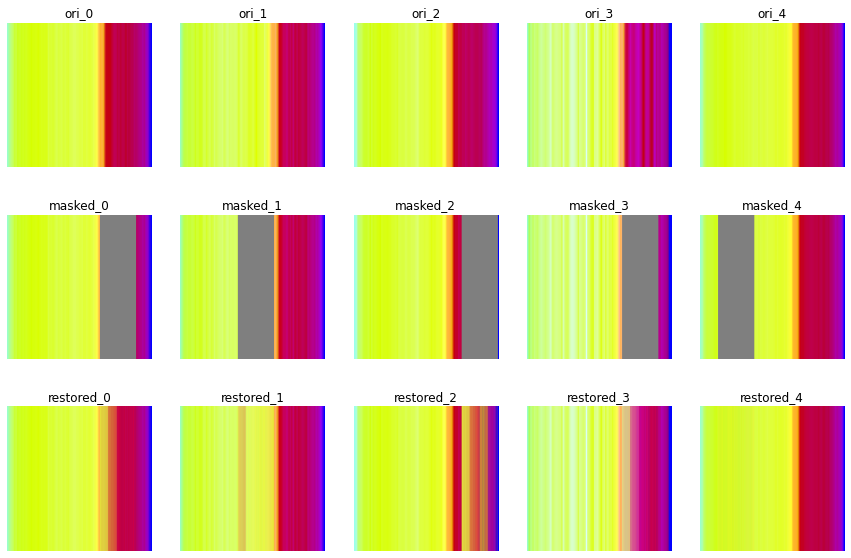

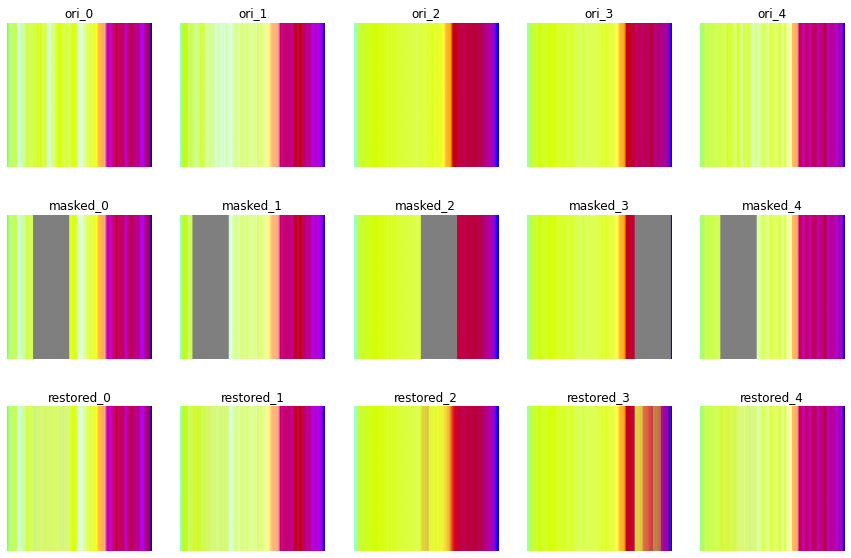

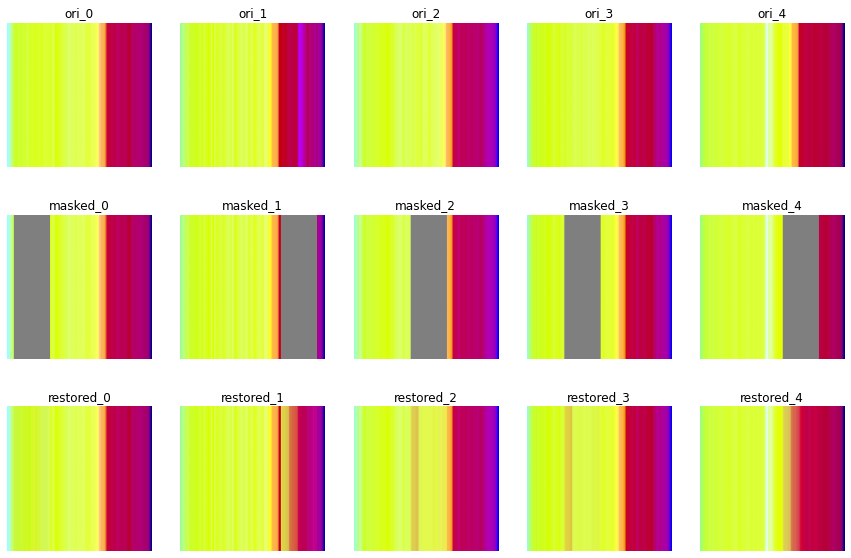

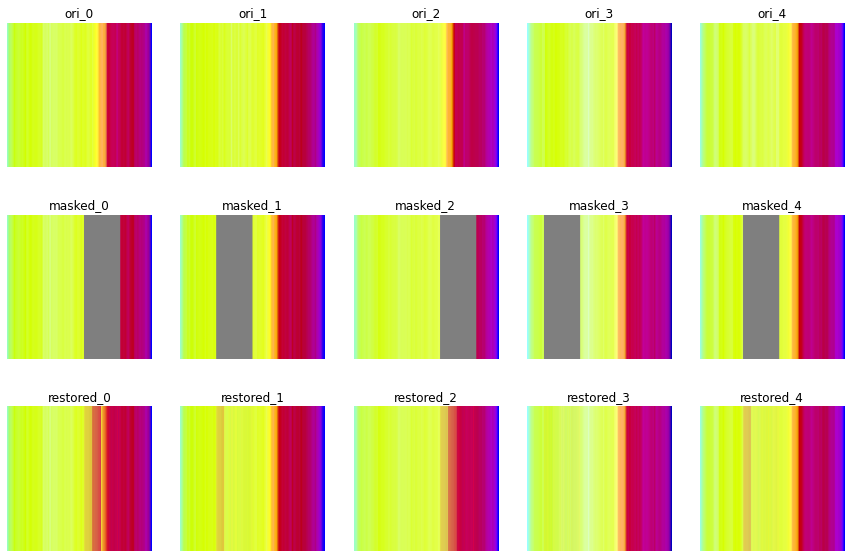

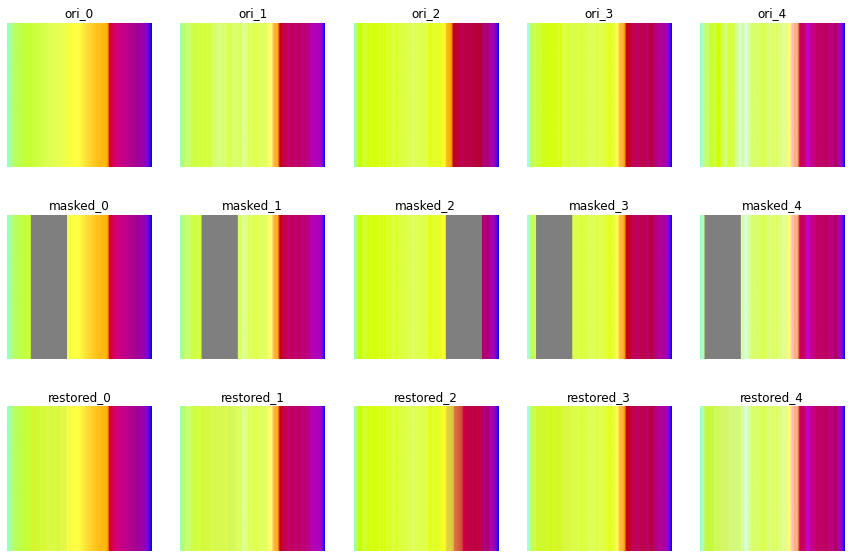

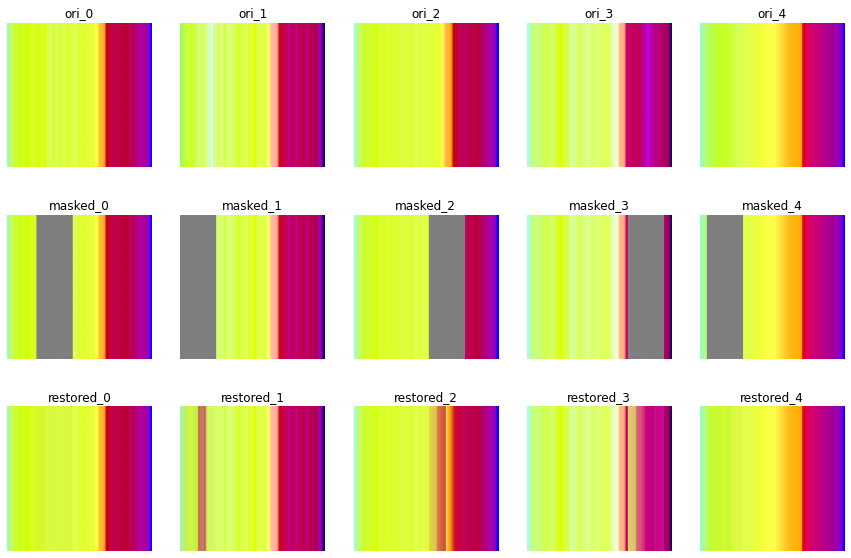

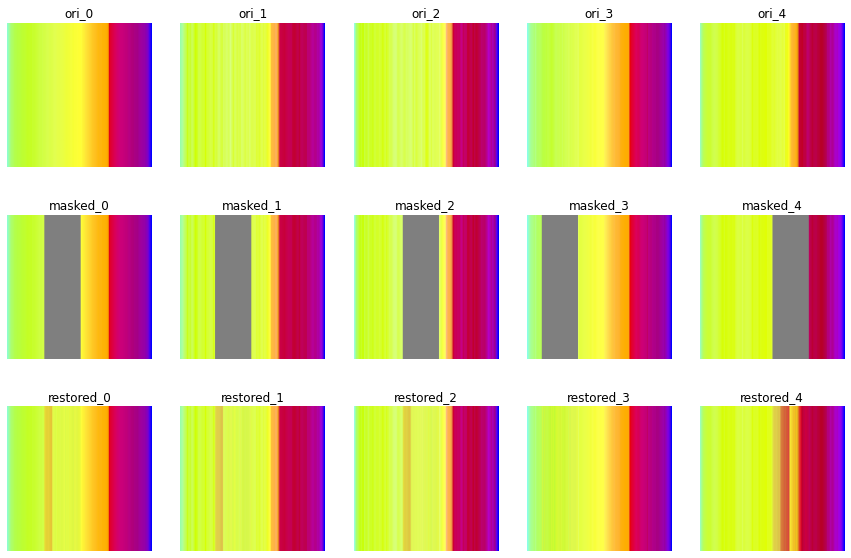

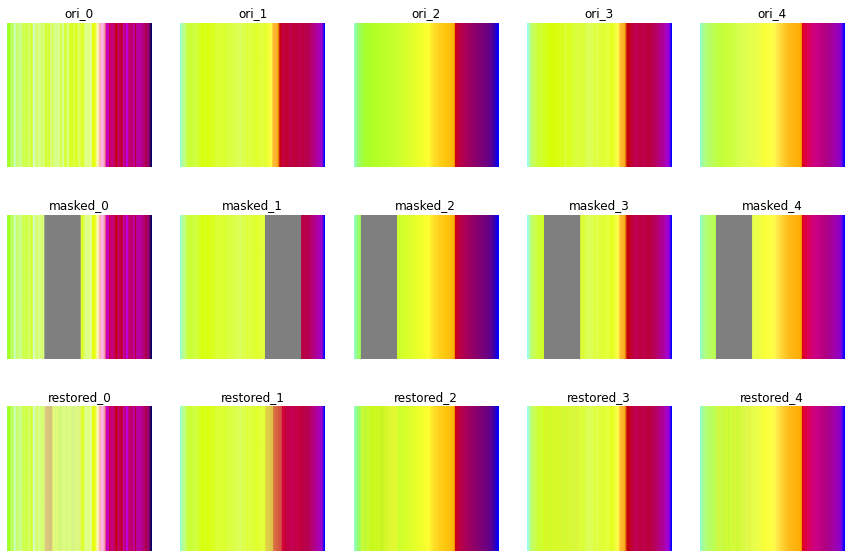

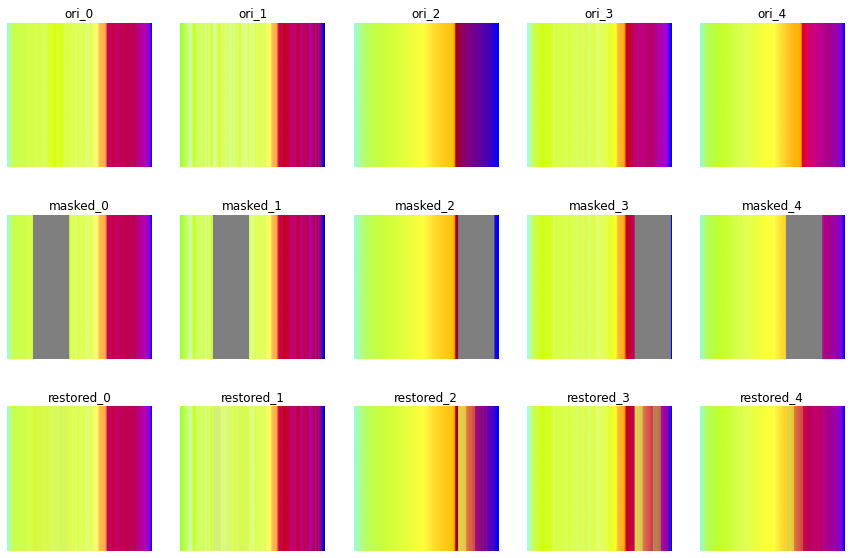

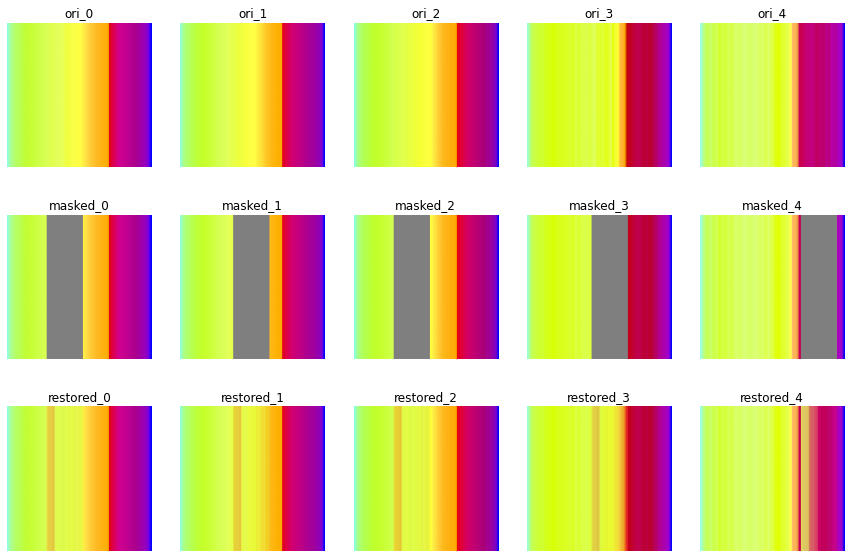

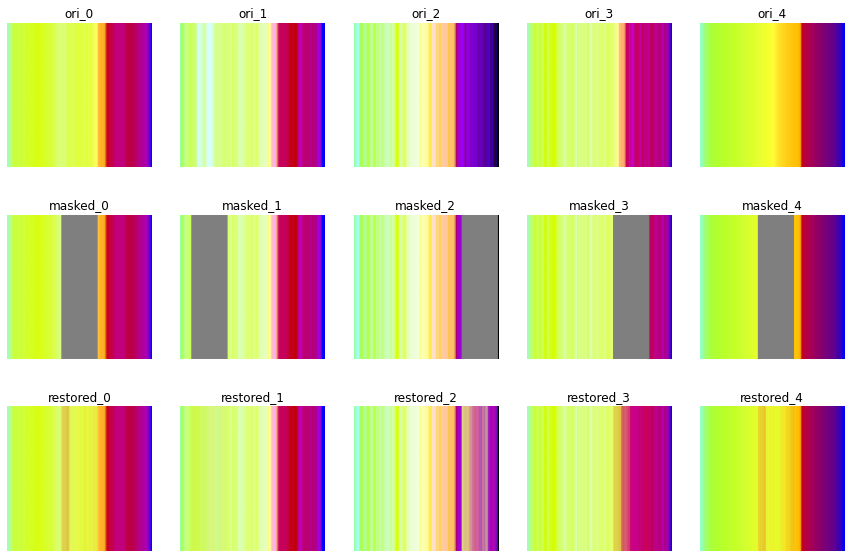

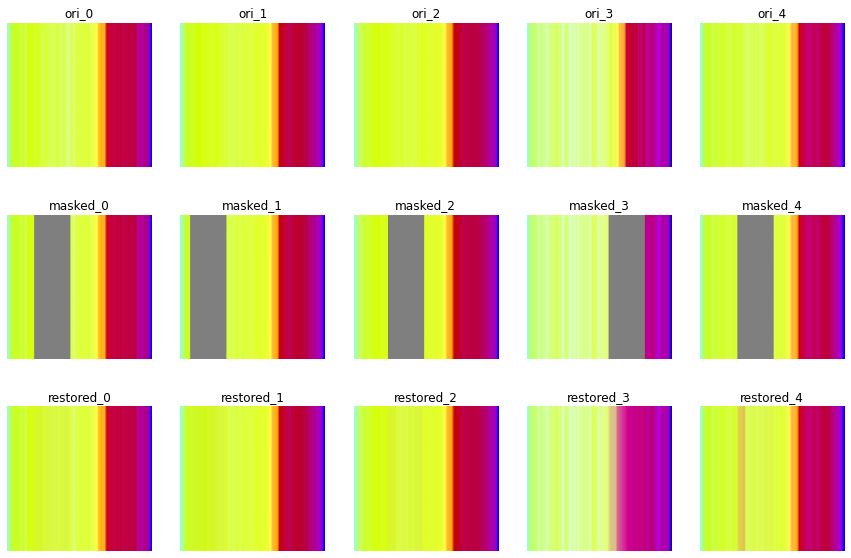

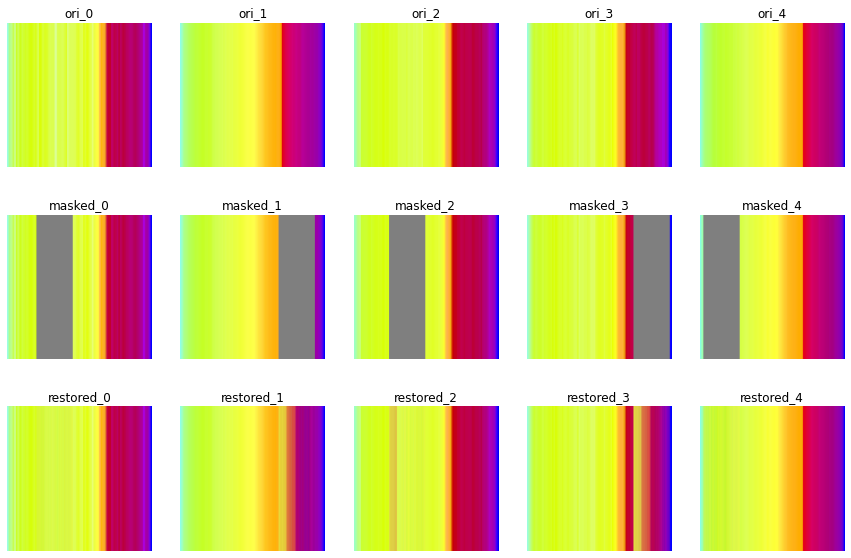

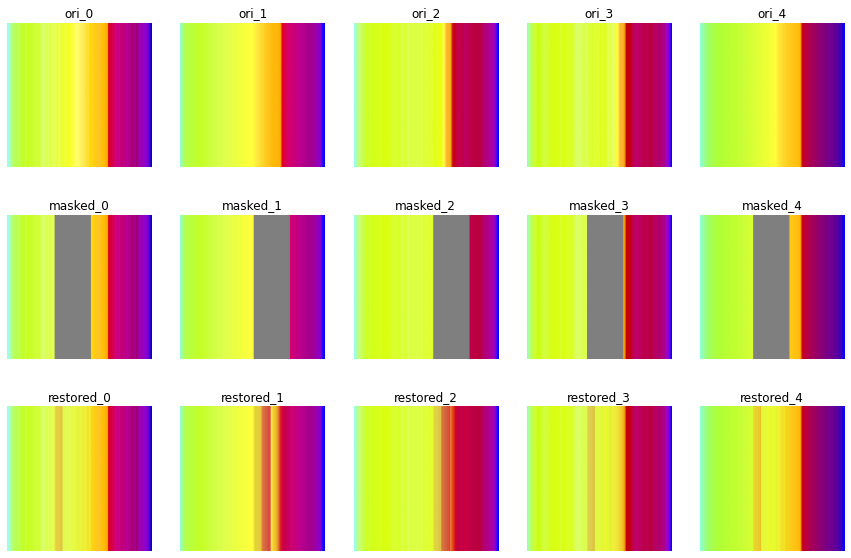

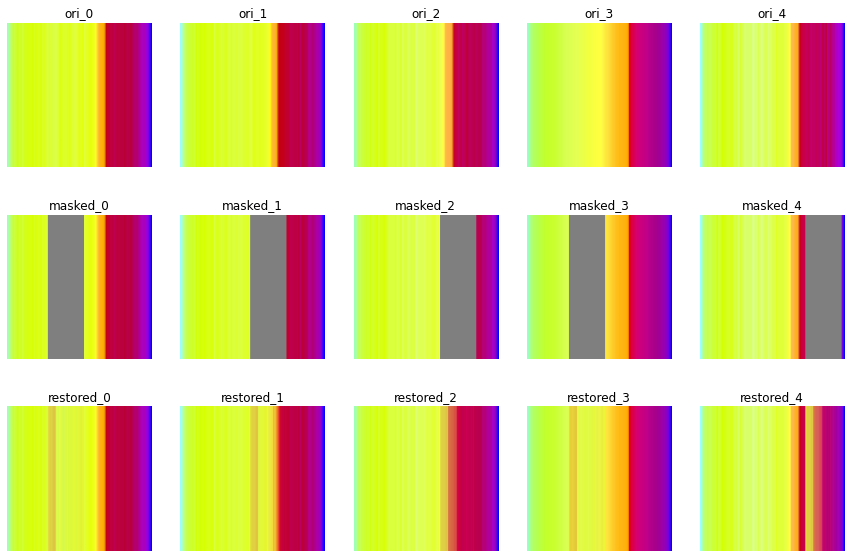

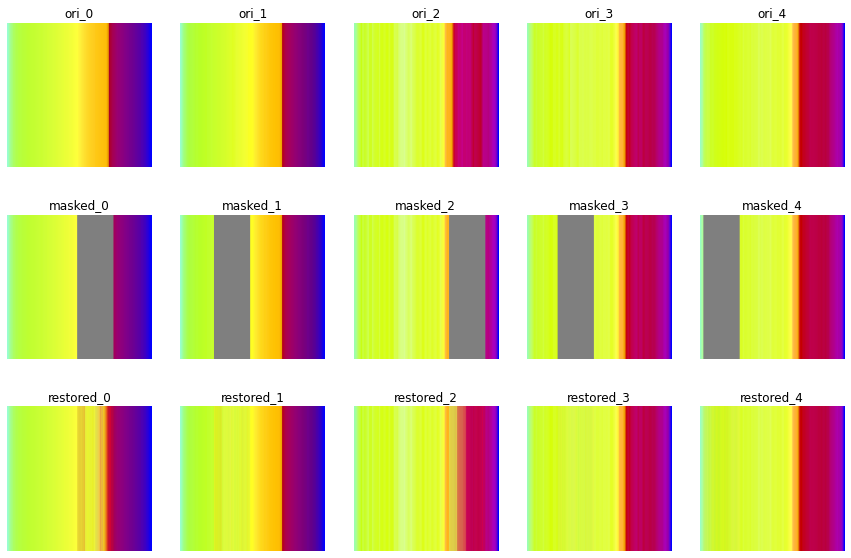

In [260]:
d, g, results_to_cnn, raw_to_cnn, cnn_index_list = train(X_train = X_train, y_train= y_train, X_test = X_test, y_test = y_test, 
                                                         epochs=300, batch_size=64, sample_interval=100)


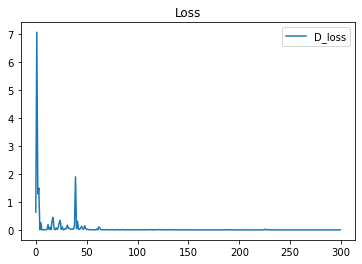

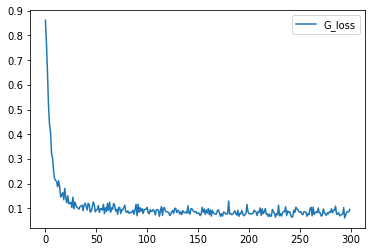

In [261]:
plt.plot(np.array(d)[:,0])
plt.title('Loss')
plt.legend(['D_loss'])
plt.show()
plt.plot(np.array(g)[:,0])
plt.legend(['G_loss'])

## 3. make dataframe for cnn

In [250]:
p = 0

results_to_cnn_final = []
for i in range(len(results_to_cnn[p])):
    results_to_cnn_final = results_to_cnn_final + results_to_cnn[p][i]
    
generated  = []
for i in range(len(results_to_cnn_final)):
    a = (results_to_cnn_final[i]*255)
    a = a.astype('int32')
    generated.append(a)
    
len(cnn_index_list[p])
soh_labels = df['SOH'].tolist()
soh_labels = y_test.tolist()

soh_labels_list = []
for i in cnn_index_list[p]:
    soh_labels_list.append(soh_labels[i][0])
    
rgb_length_list = []
for i in cnn_index_list[p]:
    rgb_length_list.append(rgb_l[i])  

In [251]:
len(generated)

100

In [252]:
x_test_gan = np.array(generated)
x_test_gan.shape
x_test_gan = x_test_gan.reshape(len(generated),128,3,1)
x_test_gan = x_test_gan.astype('float32')/255.0

## 4. SOH estimation 

In [266]:
model = load_model('/home/sbml/battery_rgb/220503/resize_not_intepolate/CNN/cnn.h5')

In [267]:
gan_data_l, cnn_reg_rmse, cnn_reg_mse, cnn_reg_mae, cnn_reg_mape = [], [], [], [], []

#cnt_l = [j * 100 for j in range(0, 30)]
cnt_l = [0]
for cnt in cnt_l:
    y_test_gan = np.array(soh_labels_list[cnt:cnt+100])
    predict = model.predict(x_test_gan[cnt:cnt+100], verbose = 0)######

    print(cnt)
    
    dic = {}
    dic['x_test_SOH'] = y_test_gan
    dic['predict_SOH'] = predict.tolist()
    data = pd.DataFrame(dic)
    gan_data_l.append(data)
    #data.to_csv('/home/sbml/battery_rgb/paper_data/codes/extra/16/16_start' + str(p) + 'try' + str(q_i) +'reg.csv')

    rmse = metrics.mean_squared_error(y_test_gan, predict)**0.5
    mse = metrics.mean_squared_error(y_test_gan, predict)
    mae = metrics.mean_absolute_error(y_test_gan, predict)
    mape = metrics.mean_absolute_percentage_error(y_test_gan, predict)

    cnn_reg_rmse.append(rmse)
    cnn_reg_mse.append(mse)
    cnn_reg_mae.append(mae)
    cnn_reg_mape.append(mape)

0


In [268]:
dic = {}
d = pd.DataFrame(dic)
d['try'] = ['try' + str(cnt_l[0])]
d['rmse'] = cnn_reg_rmse
d['mse'] = cnn_reg_mse
d['mae'] = cnn_reg_mae
d['mape'] = cnn_reg_mape
d

,try,rmse,mse,mae,mape
0,try0,0.048644,0.002366,0.037159,0.039982


In [241]:
#d.to_csv('/home/sbml/battery_rgb/220610/resize_not_intepolate/GAN/per_32.csv')